5. Ensemble Learning: Improving Performance
Project: CryptoGigel

Objective: Can we improve our predictions by combining multiple models?

Ensemble Methods Used:

Voting Ensemble: Combines the predictions of several different models (e.g., Linear + Ridge + Tree).

Regression: Averages the predictions.

Classification: Majority vote (or average probability).

Gradient Boosting: A powerful technique where models are built sequentially. Each new model tries to correct the errors of the previous one.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

# Setup visual style
sns.set_style("whitegrid")

# Load processed data
file_path = '../data/processed/bitcoin_processed.csv'
df = pd.read_csv(file_path, index_col=0)

print("Data loaded for Ensemble Learning.")

Data loaded for Ensemble Learning.


2. Data Preparation (Dual Task)
Since we are evaluating both Regression and Classification ensembles in this notebook, we prepare both targets at once.

X (Features): Same 10 technical indicators.

y_reg: Next Day Price (Continuous).

y_class: Direction (Binary).

In [2]:
# Features
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                'SMA_7', 'SMA_30', 'Pct_Change', 'Volatility', 'RSI']
X = df[feature_cols]

# Target 1: Regression (Next Day Price)
y_reg = df['Target_Next_Close']

# Target 2: Classification (Direction)
y_class = df['Target_Direction']

# Split Data (Time Series Split - No Shuffle)
# We use the same random_state/indices for consistency across tasks
X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.2, shuffle=False)
_, _, y_class_train, y_class_test = train_test_split(X, y_class, test_size=0.2, shuffle=False)

# Scale Data (Fit on Train, Transform on Test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data prepared for both Regression and Classification tasks.")

Data prepared for both Regression and Classification tasks.


3. Regression Ensembles
We attempt to beat the baseline Ridge Regression (~$1783 RMSE).

Voting Regressor: We combine Linear Regression (good baseline), Ridge (stable), and Gradient Boosting (complex).

Gradient Boosting Regressor: A standalone "Booster" model.

Note: Tree-based models (like Boosting) often struggle to predict values outside the range they saw during training (e.g., new All-Time Highs).

In [3]:
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge

print("--- REGRESSION ENSEMBLE ---")

# 1. Voting Regressor
# We combine the stability of Linear models with the complexity of Trees
reg1 = LinearRegression()
reg2 = Ridge(alpha=1.0)
reg3 = GradientBoostingRegressor(n_estimators=100, random_state=42)

voting_reg = VotingRegressor(estimators=[
    ('lr', reg1), 
    ('ridge', reg2), 
    ('gbr', reg3)
])

# Train
voting_reg.fit(X_train_scaled, y_reg_train)
voting_pred = voting_reg.predict(X_test_scaled)
voting_rmse = np.sqrt(mean_squared_error(y_reg_test, voting_pred))

print(f"Ensemble 1 (Voting) RMSE: ${voting_rmse:.2f}")

# 2. Gradient Boosting (Standalone)
gb_reg = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gb_reg.fit(X_train_scaled, y_reg_train)
gb_pred = gb_reg.predict(X_test_scaled)
gb_rmse = np.sqrt(mean_squared_error(y_reg_test, gb_pred))

print(f"Ensemble 2 (Gradient Boosting) RMSE: ${gb_rmse:.2f}")

--- REGRESSION ENSEMBLE ---
Ensemble 1 (Voting) RMSE: $3239.69
Ensemble 2 (Gradient Boosting) RMSE: $7844.89


4. Classification Ensembles
We attempt to beat the random guess (~50% Accuracy).

Voting Classifier (Soft): Combines Logistic Regression, Random Forest, and SVM.

Soft Voting: Averages the probabilities (e.g., Model A says 60% Up, Model B says 80% Up -> Average 70% Up).

Gradient Boosting Classifier: Focuses on hard-to-classify examples.

In [4]:
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

print("\n--- CLASSIFICATION ENSEMBLE ---")

# 1. Voting Classifier (Soft Voting)
clf1 = LogisticRegression()
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf3 = SVC(probability=True, kernel='rbf') # Probability=True is required for soft voting

voting_clf = VotingClassifier(estimators=[
    ('lr', clf1), 
    ('rf', clf2), 
    ('svm', clf3)
], voting='soft')

voting_clf.fit(X_train_scaled, y_class_train)
voting_class_pred = voting_clf.predict(X_test_scaled)
voting_acc = accuracy_score(y_class_test, voting_class_pred)

print(f"Ensemble 1 (Voting) Accuracy: {voting_acc:.4f}")

# 2. Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
gb_clf.fit(X_train_scaled, y_class_train)
gb_class_pred = gb_clf.predict(X_test_scaled)
gb_acc = accuracy_score(y_class_test, gb_class_pred)

print(f"Ensemble 2 (Gradient Boosting) Accuracy: {gb_acc:.4f}")


--- CLASSIFICATION ENSEMBLE ---
Ensemble 1 (Voting) Accuracy: 0.5056
Ensemble 2 (Gradient Boosting) Accuracy: 0.4915


5. Final Comparison
Did complexity pay off?

Regression: We compare RMSE. If the simple Ridge model is better than the Ensemble, it proves that financial trends are often linear and "over-engineering" hurts performance.

Classification: We compare Accuracy.

C:\Users\Alberto\AppData\Local\Temp\ipykernel_13784\666222543.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model Type', y='Score', data=comp_df[comp_df['Task'] == 'Regression (RMSE)'], palette='Reds')


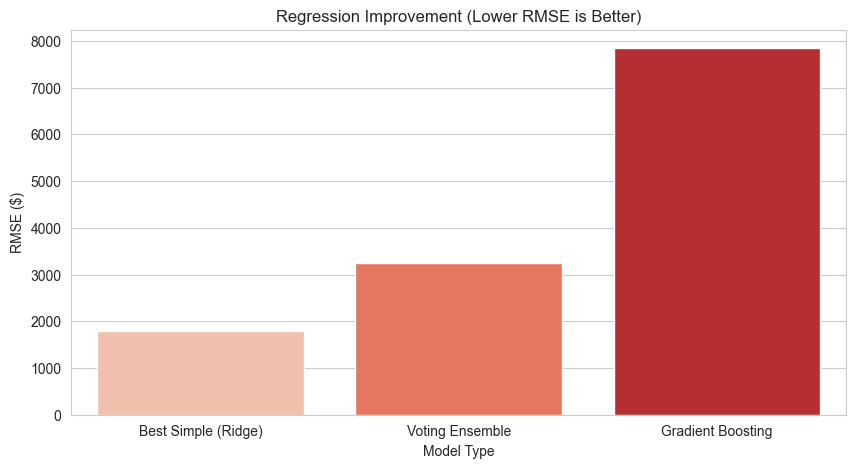

C:\Users\Alberto\AppData\Local\Temp\ipykernel_13784\666222543.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model Type', y='Score', data=comp_df[comp_df['Task'] == 'Classification (Acc)'], palette='Blues')


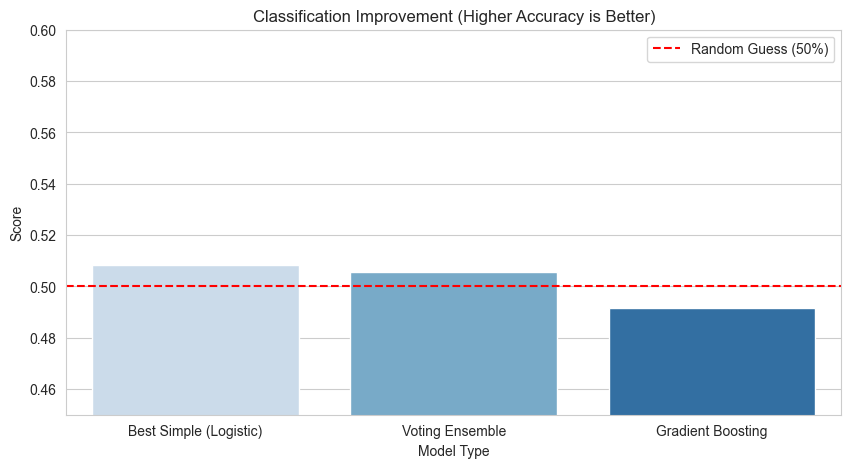

In [5]:
# Comparison Dataframe
# We hardcode the 'Best Simple Model' scores from previous notebooks for direct comparison
comparison_data = {
    'Task': ['Regression (RMSE)', 'Regression (RMSE)', 'Regression (RMSE)', 
             'Classification (Acc)', 'Classification (Acc)', 'Classification (Acc)'],
    'Model Type': ['Best Simple (Ridge)', 'Voting Ensemble', 'Gradient Boosting',
                   'Best Simple (Logistic)', 'Voting Ensemble', 'Gradient Boosting'],
    'Score': [1783.18, voting_rmse, gb_rmse,  # RMSE (Lower is better)
              0.5085, voting_acc, gb_acc]     # Accuracy (Higher is better)
}

comp_df = pd.DataFrame(comparison_data)

# 1. Regression Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='Model Type', y='Score', data=comp_df[comp_df['Task'] == 'Regression (RMSE)'], palette='Reds')
plt.title('Regression Improvement (Lower RMSE is Better)')
plt.ylabel('RMSE ($)')
plt.show()

# 2. Classification Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='Model Type', y='Score', data=comp_df[comp_df['Task'] == 'Classification (Acc)'], palette='Blues')
plt.title('Classification Improvement (Higher Accuracy is Better)')
plt.ylim(0.45, 0.60) # Zoom in to see the margins
plt.axhline(0.5, color='red', linestyle='--', label='Random Guess (50%)')
plt.legend()
plt.show()

6. Model Export for Deployment
Conclusion: Based on the results, Ridge Regression proved to be the most robust and accurate model for Price Prediction. Complex ensembles failed to extrapolate the 2024 Bull Run trend.

We save the Ridge Model and the Scaler to be used in our Streamlit App.

In [8]:
import joblib
import os
from sklearn.linear_model import Ridge

# Ensure directory exists
if not os.path.exists('../models'):
    os.makedirs('../models')

# 1. Re-train the winner (Ridge) on the training set
# We use the simple Ridge model because it outperformed the Ensembles in this specific Time Series context.
best_model = Ridge(alpha=1.0)
best_model.fit(X_train_scaled, y_reg_train)

# 2. Save Model and Scaler
model_filename = '../models/crypto_price_model.pkl'
scaler_filename = '../models/scaler.pkl'

joblib.dump(best_model, model_filename)
joblib.dump(scaler, scaler_filename)

print(f"✅ Deployment Ready!")
print(f"Best Model (Ridge) saved to: {model_filename}")
print(f"Scaler saved to: {scaler_filename}")

✅ Deployment Ready!
Best Model (Ridge) saved to: ../models/crypto_price_model.pkl
Scaler saved to: ../models/scaler.pkl
